# Document indexing with LSH Forest

Practical course material for the ASDM Class 09 (Text Mining) by Florian Leitner.

© 2016 Florian Leitner. All rights reserved.

## Introduction

Today's lab will cover the two most fundamental techniques of Text Mining: Document classification and indexing; This notebook covers the latter ("building the world's fastest search engine").

For background, please check the "Pitfalls for budding data scientists" and the "Shingling and Jaccard's similarity" notebooks.

An excellent resource for basic LSH is the free book (PDF) by Rajaraman, ["Mining of Massive Datasets"](http://infolab.stanford.edu/~ullman/mmds/book.pdf). We will specifically be looking at a "self-tuning" LSH design, the [LSH Forest by Bawa et al.](http://infolab.stanford.edu/~bawa/Pub/similarity.pdf).

Ensure you have **NLTK** installed or install it with:

- Anaconda Python: `conda install nltk`
- Stock Python: `pip3 install nltk`

Also install the `segtok` tokenization and segmentation library created by yours truly (the instructor, me):

- Anaconda Python: `conda install segtok`
- Stock Python: `pip3 install segtok`

Once done, the following imports should work; If not, you can always skip the practical document indexing examples below.

Once done, the following imports should work; If not, you can always skip the practical example at the end.

In [1]:
import nltk
import segtok
import sklearn

Ensure you have at least NLTK book (and/or popular) downloaded and installed from the dialog window that shows up.

In [2]:
#nltk.download()

In [3]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


## Jaccard's set similarity

(see the relevant Notebook for a detailed discussion)

In [4]:
def jaccard(seq1, seq2):
    """
    The Jaccard similarity between two sequences:
    |∩(X,Y)| / |∪(X,Y)|
    """
    
    x = set(seq1)
    y = set(seq2)
    return len(x & y) / len(x | y)

## Min-hash signatures

(see the "Pitfalls..." Notebook for a discussion of `hash` vs. `id`)

We will look into an implementation of LSH by [Christian Jauvin](http://cjauvin.github.io/); see [github.com/go2starr/lshhdc](https://github.com/go2starr/lshhdc) for educational puposes (but note that SciKit-Learn will provide us with the implementation we will be using).

In [5]:
class MinHashSignature:
    """Hash signatures for sets/tuples using minhash."""

    def __init__(self, dim):
        """
        Define the dimension of the hash pool
        (number of hash functions).
        """
        
        self.dim = dim
        self.hashes = self.hash_functions()

    def hash_functions(self):
        """
        Return a list of `dim` different hash functions h_n.
        """
        
        # In essence, this implements 
        # the hash permutations suggested
        # in slide "Minash signatures (1/2)"
        def hash_factory(mutator):
            # note that each element in 
            # an item being min-hashed
            # will be pushed in here, as "x"
            # I.e., x typically is a token,
            # character, or n-gram, etc.
            return lambda x: hash(
                "salt" + str(mutator) + str(x) + "salt"
            )
        
        return [ hash_factory(_) for _ in range(self.dim) ]

    def sign(self, item):
        """
        Return the minhash signatures
        for any iterable input `item` D_i.
        """
        
        sig = [ float("inf") ] * self.dim
        
        for hash_ix, hash_fn in enumerate(self.hashes):
            # minhashing (requires item is iterable):
            # c.f., slide "Minhash signatures (2/2)"
            #
            # as per the algorithm shown: for each hash
            # function, choose the hash value from that
            # input item (token, character, n-gram, etc.)
            # that has the smallest (min) hashed value
            # as the value to use in the final signature
            sig[hash_ix] = min(hash_fn(i) for i in item)
        
        return sig

A MinHash signature that generates four different hash values ("dimensions") for the same string; This signature can be understood as generating four different, random orders of the input item that gets is signed (aka., "hash-permuted row IDs" in the slides, "Minhash signatures (1/2)").

In [6]:
sig4 = MinHashSignature(4)
sig4.sign("example")

[-7299365442126544006,
 -6389310932557286797,
 -6959240971047010868,
 -8605836430286245850]

## Banded Locality Sensitive Hashing

(see the "Pitfalls..." Notebook for a discussion of floating point issues with probabity values)

In [7]:
class BandedLSH:
    # n. bands:
    # b = dictionary.hasher.size /
    #     dictionary.hasher.bandwidth
    #    
    # rows per band:
    # r = dictionary.hasher.bandwidth 
    
    def __init__(self, size, threshold):
        """
        Set up for a given similarity `threshold`
        and a given total BandedLSH `size`.
        """
        
        # total size (n. rows) of the matrix
        # (slide "Banded locality sensitve hasing")
        self.size = size
        # *desired* Jaccard similarity threshold
        # of the items belonging together
        self.threshold = threshold
        # number hashes to use per band
        # to get to that threshold
        # "rows per band"
        self.bandwidth = self.get_bandwidth(
            size,
            threshold)

    @staticmethod
    def get_bandwidth(n, t):
        """
        Approximate the bandwidth
        (number of rows in each band)
        for a fixed total number of
        rows `n` (bandwith * n. bands)
        needed to achieve the desired
        similarity threshold `t`.

        Similarity threshold t = (1. / b) ** (1. / r)
        with size (total rows in LSH) n = b * r
        where:
        b = number of bands
        r = number of rows per band
        therefore:
        b = 1 / (t ** r)
        and:
        r = n /b
        """
        
        best = n # default: 1 band with `n` rows
        minerr = float("inf") # default: "infinite" error
        
        # Try finding the smallest possible bandwith r
        # by starting with one row per band, etc:
        for r in range(1, n + 1):
            try:
                # calculate the number of bands b needed to
                # achieve the desired threshold t with the
                # current number of rows r
                b = 1. / (t ** r)
            except: # Divide by zero; size is too huge to manage
                return best
            
            # how close would the calculated number bands b
            # with the current bandwith r, 
            # required to achieve the desired threshold t,
            # be to the desired total LSH size n?
            err = abs(n - b * r)
            
            if err < minerr:
                best = r
                minerr = err
                
        return best

    def hash(self, sig):
        """
        Generate one locality-sensitive hash for each band for an
        input item D with the (min-)hashed signature `sig`.
        """
        
        # Note that this implementation requires a min-hash signature of
        # the same size as the total BandedLSH size, which is technically
        # not required (as discussed in class); We could assign the same
        # signatures to multiple bands, as long as there are sufficient
        # signature hash values to generate a unique selection of values
        # for each band.
        # But as hashing is cheap, we don't go to such lengths here...
        # Note that in the slides you see several hashes per band; here,
        # instead, we just combine those hash values (the "band") into one
        # single hash value.
        for band in zip(*(iter(sig),) * self.bandwidth):
            # the "salt" is to make this approach more robust
            # and is specific to how hashing works (out of scope here)
            yield hash("salt" + str(band) + "tlas")

    @property
    def exact_threshold(self):
        """
        The actual threshold,
        as defined by the calculated bandwith.
        """
        
        r = self.bandwidth
        b = self.size / r
        return (1. / b) ** (1. / r)

    def get_n_bands(self):
        """
        Calculate the number of bands.
        """
        
        return int(self.size / self.bandwidth)

The zip-list iterated over in `BandedLSH.hash` is simply the min-hash signature values subset for each band. E.g., assuming `size = 6` for the BandedLSH and, therefore, also for the min-hash `signature` (see inline comments, we just use as many min-hashes as we have total rows), and assuming we calculated a `bandwidth` of `2` with `BandedLSH.get_bandwidth`:

In [8]:
signature = [1,2,3,4,5,6]
bandwidth = 2
list(zip(*(iter(signature),) * bandwidth))

[(1, 2), (3, 4), (5, 6)]

Therefore, what we get out of `BandedLSH.hash` is one **hash value** for each **band** given an item's (min-hash) `signature` and the (calculated) LSH `bandwidth`:

In [9]:
list(
    map(
        hash,
        zip(*(iter(signature),) * bandwidth)
    )
)

[3713081631934410656, 3713083796997400956, 3713085962043070856]

If the bandwith had been `3`:

In [10]:
print(signature)
list(zip(*(iter(signature),) * 3))

[1, 2, 3, 4, 5, 6]


[(1, 2, 3), (4, 5, 6)]

Pay attention to number of bands. This indicates how "hard" the threshold can be cut off. If this number is small, you might very fuzzy clusters (i.e., a very streched sigmoid in the plot below). The bandwidth (rows/band) in turn is proportional to the (desired) Jaccard similiarty (the horizontal position of the sigmoid curve).

To visualize the "cutoff hardness" of your setup, you can visualize the probability of two documents being added to the same cluster (i.e., set of buckets) as a function of their Jaccard similarity. (see slide "Banded Locaility Sensitive Minhashing", $p_{agreement}$)

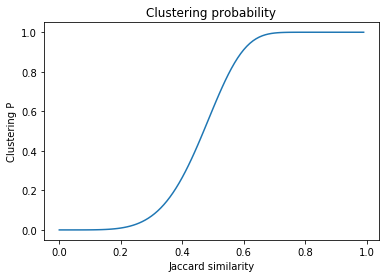

In [11]:
bandwidth = 30
rows_per_band = 5
p_agreement = lambda sim: 1 - (1 - sim**rows_per_band)**bandwidth
x = np.arange(0.0, 1.0, 0.01)

plt.plot(x, p_agreement(x))
plt.title('Clustering probability')
# (as a function of bandwidth and n. bands)
plt.xlabel('Jaccard similarity')
plt.ylabel('Clustering P')
plt.show()

Feel free to play around with the above cell, chaning `bandwidth` and `rows per band` to understand how those two parameters influnce the likelihood of two documents sharing *at least one bucket* given their Jaccard similarity.

## Document indexing

While the toy implementation above was practical to discuss the algorithm, we will be using a special [LSH **Forest**](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LSHForest.html#sklearn-neighbors-lshforest) implementation to retrieve the closest matching document given a query (document).

Another attractive LSH implemention is avaliable from the [`datasketch`](https://ekzhu.github.io/datasketch/lsh.html) Python library.

### Corpus preparation

In [12]:
from sklearn.datasets import fetch_20newsgroups

from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from segtok.segmenter import split_multi
from segtok.tokenizer import word_tokenizer, split_contractions

stemmer = PorterStemmer()
train, test = fetch_20newsgroups(), fetch_20newsgroups(subset='test')

stopwords_en = frozenset(stopwords.words('english'))
stopwords_none = frozenset([])


def tokenize(raw_text):
    """
    Convert text to lower-case tokens of length > 2.
    """
    
    for sentence in split_multi(raw_text):
        for raw in split_contractions(word_tokenizer(sentence)):
            token = raw.lower()
            
            if len(token) > 2 and any(c.isalnum() for c in token):
                yield token

                
def filter_and_stem(raw_text, stopwords):
    
    for token in tokenize(raw_text):
        yield token
        if token not in stopwords:
            yield stemmer.stem(token)
        else:
            yield None
                
                
def shingle(
    raw_text,
    stopwords=stopwords_none,
    bigrams=False):
    """
    Shingle text to stop-word-free,
    stemmed uni- and bi-grams.
    """
    
    last = None
    
    for t in filter_and_stem(raw_text, stopwords):
        if t is not None:
            yield t
            
            if bigrams and last is not None:
                yield "{}_{}".format(last, t)
            
        last = t

print("Corpus sizes: train =",
      len(train.data),
      "; test =", len(test.data))

Corpus sizes: train = 11314 ; test = 7532


Let's have a look at how that tokenization/shingling works on a document in our collection:

In [13]:
example = train['data'][0].strip()
print(example)

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----


In a real-world scenario, you'd probably start cleaning up the above "mess", removing the header and possibly the footers from the messages.

You can either use `tokenize` to work with single tokens, or `shingle` to work with [higher] n-grams and stopword-filtering, too.

In [14]:
tokens = frozenset(shingle(example))
print(" ".join(tokens))

front tellm addition there years out lerxst other university sports thing this info car thi wa engin body maryland earli all early whatever park can name thanks e-mail anyone 70s saw bumper were univers rest organ nntp-posting-host know called pleas doors production realli tellme line 60s model really separate what bricklin engine from looking neighborhood enlighten was histori thank product separ sport wonder lines 60 your please wam.umd.edu subject day made looked call brought look year you colleg funky addit could door have 2-door where college 70 history the wondering whatev rac3.wam.umd.edu specs late anyon funki small spec organization bodi


Now convert the whole 20News *train* corpus into tokens - this can take a while (possibly 5 minutes!) on most machines.

In [15]:
%time corpus = [frozenset(shingle(doc)) for doc in train['data']]

CPU times: user 4min 13s, sys: 4.02 s, total: 4min 17s
Wall time: 4min 20s


### Similarity threshold estimation

First, we'd like to find out how our document similarity behaves across our corpus.
To do that we select a random "target" document and compute it's Jaccard similiary against all other documents.

other doc with max. Jaccard similarity = 0.15346534653465346
Mean Jaccard similarity = 0.0763576100964
Median Jaccard similarity = 0.07659574468085106


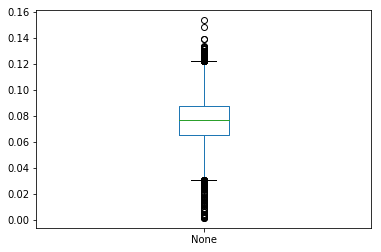

In [16]:
import pandas as pd
import random

target = random.choice(range(len(corpus)))
others = [i for i in range(len(corpus)) if i != target]
jsim = lambda i: jaccard(corpus[target], corpus[i])
max_sim = max((jsim(i) for i in others))

print("other doc with max. Jaccard similarity =",
      max_sim)

sims = pd.Series(jsim(i) for i in others)
print("Mean Jaccard similarity =", sims.mean())
print("Median Jaccard similarity =", sims.median())
sims.plot.box()

Rerun the above cell a few times to get a feeling for the similarty.

What you can see is that "plain" LSH will *not* be very useful for **clustering** our corpus (represented as _bags-of-words_), because most documents have a very low similiarty to each other.
Rather, where LSH shines is detecting duplicates or even plagiarism, because then the Jaccard simliarity is (very) high.

### LSH Forest setup

A special variant of LSH, LSH *Forest*, is able to detect the best match for a query (document) if there is any reasonable Jaccard similarity between that query and some document in your collection.
In addition, and as before for the document classification, we set up a TF-IDF document vectorizer.

In [17]:
%%time

from sklearn.neighbors import LSHForest
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    min_df=3,
    max_df=0.5,
    #ngram_range=(1,2),
    token_pattern='(?u)(?:\\b|(?<=_))[^\W_][^\W_]+(?:\\b|(?=_))',
)
# train (aka, fit) the vectorizer to the train data:
X_train = vectorizer.fit_transform(train.data)

classifier = LSHForest(n_estimators=25, n_neighbors=1)
classifier.fit(X_train)

CPU times: user 9.23 s, sys: 387 ms, total: 9.62 s
Wall time: 9.69 s


Great, we've indexed all our documents in virtually no time! Please let this sink in for a moment - most search engines spend ages indexing content, while this solution hardly spends any noticable time at all (compared to the collection size, over 10,000 documents).

The parameter that has the strongest impact on indexing and search times is `n_estimators`, but increasing it improves the retrieval quality. Depending on your needs, you will almost certainly want to adjust that parameter to your use-case. The `n_neighbors` parameter only sets the default number of document returned by a query; We are here only evaluating how LSH Forest performs "on its own", so setting this to one is great. Under normal circumstances, you might want to use a higher value and among the returned values check for the best value to further remove any error, avoiding false positives, and/or to present the user with a result *list* (instead of the best result only). For the reamining parameters, please refer to the [SciKit-Learn documentation](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LSHForest.html#sklearn.neighbors.LSHForest).

## Document search

Now, lets use this classifier to predict the nearest neighbor for each of the "test" documents that we did not yet index (so this isn't just trivially returning exact matches).

In [ ]:
%%time

# with the fitted vectorizer, transform the test data:
X_test = vectorizer.transform(test.data)

# now run the queries:
indices = classifier.kneighbors(
    X_test,
    n_neighbors=1,
    return_distance=False)

CPU times: user 2min 32s, sys: 2.64 s, total: 2min 35s
Wall time: 2min 36s


What is quite noteworthy here is the time it took to search our documents. We searched for around 7,000 documents in a pool of almost 12,000; So each query just took a small fraction of a second!

## Evaluation

Now lets try to randomly query for 10 documents using exact maching to give you an idea just how blazingly fast the above was generated. Also, lets evaluate how good our index is; That is, the mean "true" rank of the document reported as the best match for those ten cases.

In [ ]:
%%time 

trr = 0.0 # total reciprocal rank
n_queries = len(test['data']) // 100
samples = random.sample(list(enumerate(indices)), n_queries)

for i, (prediction,) in samples:
    # 'encode' the query
    # ~ vectorizer.transform
    query = frozenset(shingle(test['data'][i]))
    
    # compare query each doc in corpus - this is the most costly part
    # ~ classifier.kneighbors 1/2
    pairs = [(jaccard(corpus[idx], query), idx)
             for idx in range(len(corpus))]
    
    # sort and reverse the results (also costly, but much less)
    # ~ classifier.kneighbors 2/2
    pairs = list(reversed(sorted(pairs)))
    
    # finally, generate and print some statistics for evaluation
    max_val = pairs[0]
    _, correct_ranking = zip(*pairs)
    rank = correct_ranking.index(prediction) + 1
    sim = 0.0
    
    if rank == 0:
        rank = len(corpus)
    else:
        sim = pairs[rank-1][0]

    trr += 1 / rank
        
    # report a few cases
    if random.random() < 0.2:
        print("prediction: rank = %5d" % rank,
              "@ Jaccard sim. = %.3f" % sim,
              "; true doc: sim. = %.3f" % max_val[0])

mrr = trr / n_queries # mean reciprocal rank
print("\nmean rank = %.0f\n" % (1 / mrr)) # estimated mean rank

prediction: rank =   610 @ Jaccard sim. = 0.120 ; true doc: sim. = 0.329
prediction: rank =  1449 @ Jaccard sim. = 0.092 ; true doc: sim. = 0.195


As you can see, this process is around one to two orders of magnitude slower (notice that we queried 100 times less documents than before against LSH Forest, but that fraction about the same time to run).

Another useful insight is that when the predicted document isn't the first, the overall best document ("`true doc: sim.`") tends to be of relatively low similarity, too - so we might argue that those are cases where there's no good match to start with.

## Conclusion

Admittedly, document clustering with LSH is a bit of a black art. But then, about any data sketching is mostly black art... However, getting this right is extremely rewarding, because indexing documents using only hashes is probably the most performant and scalable path towards building a super-fast query engine - even if it is anything but "exact science", in a quite literal sense.